In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('seaborn-ticks')

### Домашние задания

1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  
2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются веса и X, на выходе - массив y_pred_proba).
4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются веса и X, на выходе - массив y_pred).
5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.
6. Могла ли модель переобучиться? Почему?
7. (\*) Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log. 

In [3]:
a = np.array([0, 0, 0.2, 0.4, 0.6, 0.8, 1, 1])
print(a)

a1 = a.copy()
a1[a1 == 1] = 1 - 1e-16
a1[a1 == 0] = 1e-16
print(np.log(a1[0]), np.log(1 - a1[-1]))

a2 = np.minimum(np.maximum(a, 1e-16), 1 - 1e-16)
print(a2[0], a2[-1])

print(np.where(a == 0, 1e-16, a))

np.clip(a, 1e-16, 1 - 1e-16, out=a)
print(a)

print(np.log1p(0)) # np.log1p(x) == np.log(x + 1)

[0.  0.  0.2 0.4 0.6 0.8 1.  1. ]
-36.841361487904734 -36.7368005696771
1e-16 0.9999999999999999
[1.e-16 1.e-16 2.e-01 4.e-01 6.e-01 8.e-01 1.e+00 1.e+00]
[1.e-16 1.e-16 2.e-01 4.e-01 6.e-01 8.e-01 1.e+00 1.e+00]
0.0


In [4]:
def calc_logloss(y, y_pred):
    np.clip(a=y_pred, a_min=1e-16, a_max=(1 - 1e-16), out=y_pred) # ограничивает значения 
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [5]:
y_true = np.array([0, 1])
preds = np.array([1, 0], dtype='float64')
calc_logloss(y_true, preds)

36.78908102879092

2. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [6]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64).T # квалификация репетитора

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # подходит или нет репетитор

def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

X_st = X.copy()
X_st[:, 2] = calc_std_feat(X[:, 2])

In [7]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

def eval_LR_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        w -= alpha * (2/n * np.dot((y_pred - y), X))
    err = calc_logloss(y, y_pred)
    return w, err

In [8]:
err = []
a = 1e-4
alpha_list = []

while a != 100:
    alpha_list.append(a)
    for it in range(1000, 20000, 5000):
        _, e = eval_LR_model(X_st, y, iterations=it, alpha=a)
        err.append(e)
    print(a)
    a *= 10
print(err)

0.0001
0.001
0.01
0.1
1.0
10.0
[0.8808932710318846, 0.584565702551288, 0.5656087745805954, 0.5540511293547943, 0.5686375214824538, 0.5178332758194601, 0.4954329729251007, 0.47809609525769226, 0.49942773443716704, 0.39199069887976884, 0.3464142641918901, 0.3207657104213656, 0.3533582423197489, 0.24130577335421677, 0.2024984800482502, 0.17810792363547237, 0.19741197512983705, 0.10810946026664814, 0.08810032416954146, 0.07743773980180915, 0.15850989324697093, 0.017353402299831063, 0.014022255640456838, 0.01173974828648626]


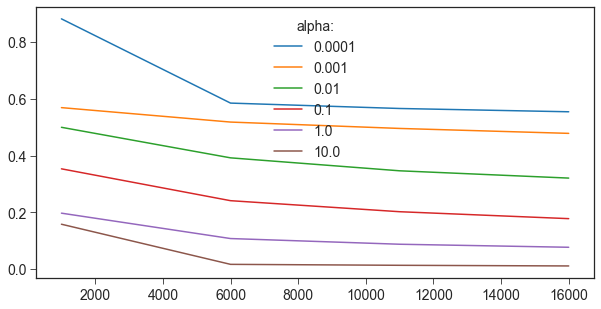

In [31]:
it = range(1000, 20000, 5000)
n = len(it)
for i in range(len(alpha_list)):
    plt.plot(it, err[(n * i):(n + n * i)], label=alpha_list[i])
plt.legend(title='alpha:');

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred_proba).

In [10]:
def calc_pred_proba(X, w):
    p = sigmoid(np.dot(X, w))
    #p = 1 / (1 + np.exp(-np.dot(X, w)))
    return p

In [11]:
w, _ = eval_LR_model(X_st, y, 2000, 1e-2)
preds = calc_pred_proba(X_st, w)
preds

array([0.27692318, 0.37168629, 0.71311155, 0.32248341, 0.81983608,
       0.64781796, 0.88429155, 0.187763  , 0.25569381, 0.8106174 ])

In [12]:
calc_logloss(y, preds)

0.4663317397156385

4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются значения массива Х и веса, посчитанные функцией eval_model, на выходе - массив y_pred).

In [13]:
def calc_pred(X, w, threshold=0.5):
    probs = calc_pred_proba(X, w)
    # labels = np.where(probs >= threshold, 1, 0)
    labels = (probs >= threshold).astype(int)
    return labels

In [14]:
print(calc_pred(X_st, w))
print(y)

[0 0 1 0 1 1 1 0 0 1]
[0 0 1 0 1 0 1 0 1 1]


5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.

In [15]:
def metrics(y, y_pred):
    TP = ((y == 1) & (y_pred == 1)).sum() # 4
    TN = ((y == 0) & (y_pred == 0)).sum() # 4
    FN = ((y == 1) & (y_pred == 0)).sum() # 1
    FP = ((y == 0) & (y_pred == 1)).sum() # 1
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    TPR = recall = TP / (TP + FN)  
    FPR = FP / (FP + TN) 
    precision = TP / (TP + FP)  
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [16]:
y_pred = calc_pred(X_st, w)
print('Accuracy: \t{:.2}\nRecall: \t{:.2}\nPrecision: \t{:.2}\nF1-score: \t{:.2}'\
      .format(*metrics(y, y_pred)[:]))

Accuracy: 	0.8
Recall: 	0.8
Precision: 	0.8
F1-score: 	0.8


In [17]:
accuracy = 100.0 - np.mean(np.abs(y_pred - y) * 100.0)
accuracy

80.0

In [18]:
cmatrix = np.zeros((2, 2))
for i in range(len(y)):
    cmatrix[y[i]][y_pred[i]] += 1
cmatrix.astype(int)

array([[4, 1],
       [1, 4]])

6. Могла ли модель переобучиться? Почему?

Могла. Очень мало наблюдений. 


7. *Создайте функции eval_LR_model_l1 и eval_LR_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [19]:
def eval_LR_model_L1(X, y, iterations=1000, alpha=1e-2, lambda_=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        w -= alpha * (2/n * np.dot((y_pred - y), X) + lambda_ * np.sign(w))
    err = calc_logloss(y, y_pred)
    return w, err

In [20]:
def eval_LR_model_L2(X, y, iterations=1000, alpha=1e-2, lambda_=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        w -= alpha * (2/n * np.dot((y_pred - y), X) + 2 * lambda_ * w)
    err = calc_logloss(y, y_pred)
    return w, err

In [21]:
eval_LR_model_L2(X_st, y, iterations=2000, alpha=1, lambda_=0)

(array([-24.4174888 ,  -2.58284232,  -6.32811374,  20.13980868]),
 0.15872806654866337)

In [22]:
w, error = eval_LR_model_L1(X_st, y, iterations=2000, alpha=1, lambda_=0.01)
print(w, error)
print(calc_pred_proba(X_st, w).round(2))
print(calc_pred(X_st, w))
print(y)

[-11.05748915  -1.76891614  -2.20959734   9.41508134] 0.265533449300239
[0.22 0.1  0.99 0.15 0.57 0.3  1.   0.01 0.27 0.98]
[0 0 1 0 1 0 1 0 0 1]
[0 0 1 0 1 0 1 0 1 1]


In [30]:
w, error = eval_LR_model_L2(X_st, y, iterations=2000, alpha=1, lambda_=0.01)
print(w, error)
print(calc_pred_proba(X_st, w).round(2))
print(calc_pred(X_st, w, threshold=0.8))
print(y)

[-2.89131056 -2.07024918  2.11014787  7.41878415] 1.3980407610491756
[0.6  0.78 1.   0.7  1.   0.98 1.   0.96 0.54 1.  ]
[0 0 1 0 1 1 1 1 0 1]
[0 0 1 0 1 0 1 0 1 1]


**Вывод:** с увеличением коэффициента регуляризации веса уменьшаются, а ошибка растет. L2 регуляризация штрафует сильнее, чем L1.

### P.S. LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(solver='liblinear',
                           penalty='l2',
                           C=10, # 1/lambda
                           fit_intercept=False, 
                           max_iter=2000, 
                           random_state=42)
model.fit(X_st, y)
y_pred = model.predict(X_st)

In [25]:
confusion_matrix(y, y_pred)

array([[4, 1],
       [1, 4]], dtype=int64)

In [26]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [27]:
model.coef_

array([[-2.29597558, -0.79352303,  0.40243552,  2.6563179 ]])

In [28]:
w

array([-2.89131056, -2.07024918,  2.11014787,  7.41878415])